In [1]:
import matplotlib # Importing matplotlib for it working on remote server
import matplotlib.pyplot as plt
import matplotlib.colors as color
%matplotlib inline

import numpy as np

import os, sys
home_dir = os.getcwd()

import torch

# because train
import random
random.seed(121)
torch.manual_seed(121)
torch.cuda.manual_seed(121)
torch.backends.cudnn.deterministic = True

import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms

import itertools, time

import simple_flint as flint
import tweak_image as tweak

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
train_shuffle = True
test_shuffle = True
train_epoch_info = []
test_epoch_info = []

criterion = nn.CrossEntropyLoss()
criterion2 = nn.L1Loss()

dataset = "cifar10"

In [3]:
print(torch.cuda.is_available())
print(device)

True
cuda


In [4]:
n_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
N_EPOCH = 25
norm_mean = (0.5,0.5,0.5) #(0.4914, 0.4822, 0.4465)
norm_std = (0.5,0.5,0.5) #(0.247, 0.243, 0.261)    
train_loader = torch.utils.data.DataLoader( datasets.CIFAR10(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.RandomCrop(32, padding=2), transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ])), batch_size=64, shuffle=train_shuffle, num_workers=32)
test_loader = torch.utils.data.DataLoader( datasets.CIFAR10(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ])), batch_size=32, shuffle=test_shuffle, num_workers=20) #batch_size 32
train_data = datasets.CIFAR10(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ]))
test_data = datasets.CIFAR10(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
latent_size = 36
f = flint.MyResNet(version='34', bn=False, n_classes=10, in_maps=3).to(device)
g = flint.attr_RN18_multi(out_size=latent_size).to(device)
d = flint.decode_CIFAR(in_size=latent_size).to(device)
h = flint.explainer(in_size=latent_size, n_classes=10).to(device)
optimizer = optim.Adam(itertools.chain(f.parameters(), g.parameters(), d.parameters(), h.parameters()), lr=0.0001)

In [6]:
model='cifar10_norm11.pt'
checkpoint1 = torch.load('output/' + dataset + '/'+model, map_location='cpu') # For MNIST
f.load_state_dict(checkpoint1['f_state_dict'])
g.load_state_dict(checkpoint1['g_state_dict'])
h.load_state_dict(checkpoint1['h_state_dict'])
d.load_state_dict(checkpoint1['d_state_dict'])
f, g, h, d = f.eval(), g.eval(), h.eval(), d.eval()

In [7]:
facc, fidelity, gacc = flint.analyze(f, g, h, d, device, test_loader, '')
print ("Accuracy of f (in %):", np.diag(facc).sum()*100/len(test_data))
print ("Accuracy of g (in %):", np.diag(gacc).sum()*100/len(test_data))
print ("Fidelity of g (in %):", np.diag(fidelity).sum()*100/len(test_data))

Accuracy of f (in %): 84.93
Accuracy of g (in %): 84.86
Fidelity of g (in %): 95.64


In [8]:
mults = [1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
conciseness = flint.sparse_sense(f, g, h, test_data, device, mults)
print (conciseness)

[1.1973, 1.4423, 1.6398, 1.8462, 2.2913, 2.7862]


Generating explanations
Writing images in an old folder. May overwrite some files
Saving images
(10, 36)


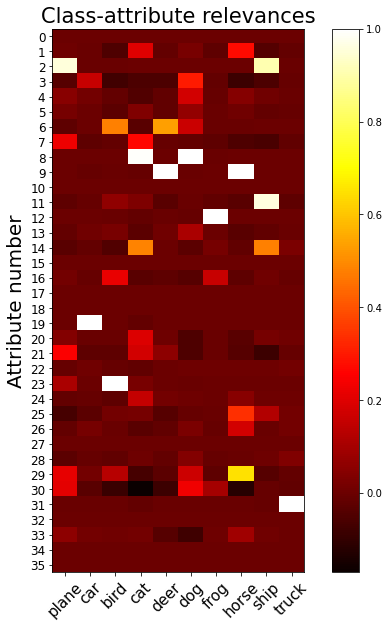

In [9]:
print ('Generating explanations')
global_rel = flint.generate_model_explanations(f, g, h, d, train_data, device, dataset, checkpoint1, model_name='sample_model', subset=True)
print(global_rel.shape)
flint.plot_rel(global_rel, 'cifar10', classes)

Predicted class: truck


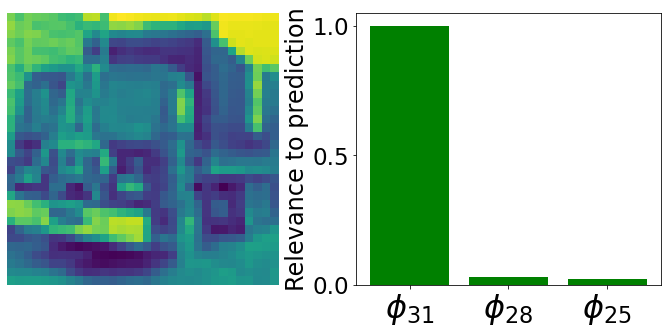

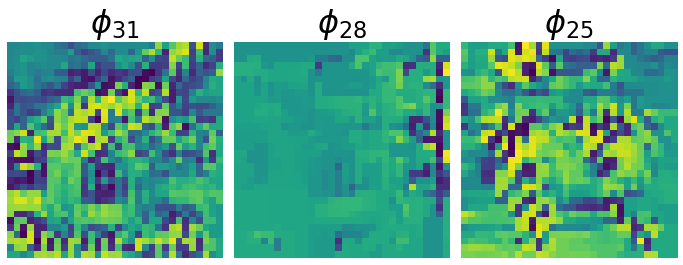

In [10]:
im1, im2 = flint.analyze_img(f, g, h, d, test_data, classes, device, 14, n_attr=3, save=False, location=None)

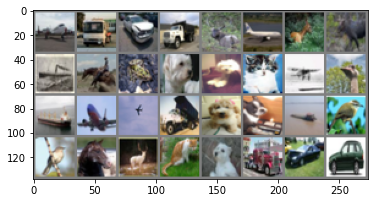

GroundTruth:  plane truck   car truck  deer plane  deer  deer  ship horse  frog   dog   dog   cat plane  bird  ship plane plane truck   dog   dog  ship  bird  bird horse  deer   cat   dog truck   car   car


In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
tweak.imshow(torchvision.utils.make_grid(images),norm_mean, norm_std)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(images.shape[0])))

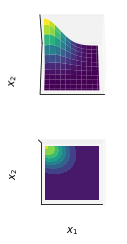

deformation maxi: 0.5696834598676144
sigX 0.3335232343475809
sigY 0.259100596981391
cov 0.09146608574423903


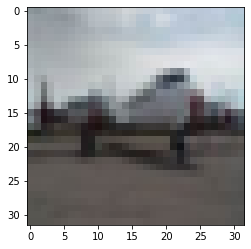

plane


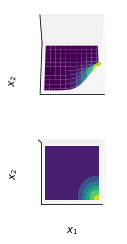

deformation maxi: 0.8023541382516229
sigX 0.17091817241361512
sigY 0.23220196749472688
cov 0.01846234191104277


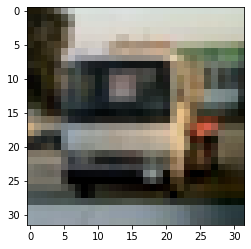

truck


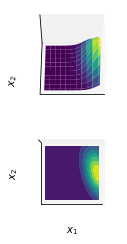

deformation maxi: 0.7889350620097192
sigX 0.1233283003450159
sigY 0.39061607411103794
cov 0.08721231878307287


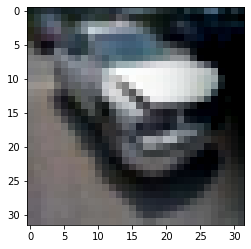

car


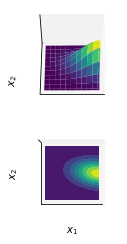

deformation maxi: 0.7507001413691443
sigX 0.4222261879755306
sigY 0.10975909373357094
cov 0.04286049602293035


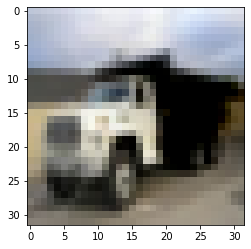

truck


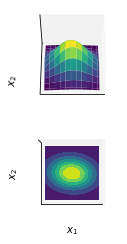

deformation maxi: 0.6868023370826336
sigX 0.33531431922118904
sigY 0.15972194477056978
cov 0.018327050231206756


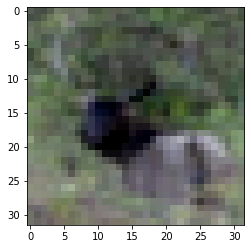

deer


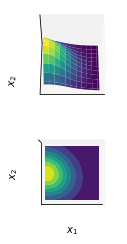

deformation maxi: 0.3880554010531895
sigX 0.47475932012774336
sigY 0.35917554923082673
cov 0.05297463274634622


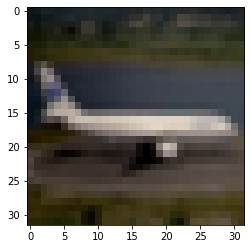

plane


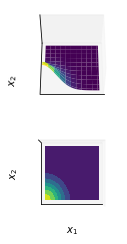

deformation maxi: 0.6472146435458209
sigX 0.22898065779271393
sigY 0.2650098324483031
cov 0.01454719966867788


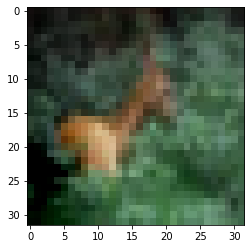

deer


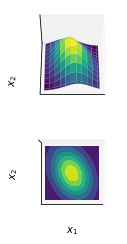

deformation maxi: 0.5319822991202882
sigX 0.24645917526590672
sigY 0.39460730732345395
cov 0.09071633637796538


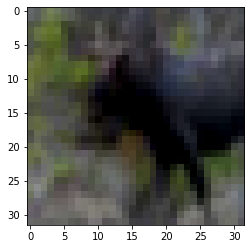

deer


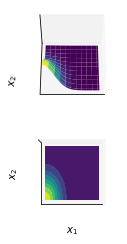

deformation maxi: 0.6086668200891439
sigX 0.15467255969834987
sigY 0.4420527005621776
cov 0.0009969753734948906


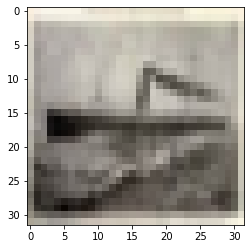

ship


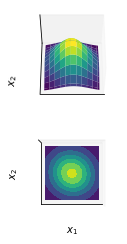

deformation maxi: 0.4983292105294394
sigX 0.32538332059179753
sigY 0.3130228464330718
cov 0.021718290443339918


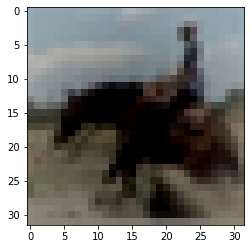

horse


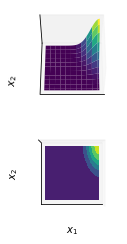

deformation maxi: 0.8175137988111721
sigX 0.10218406977118458
sigY 0.3847988365032259
cov 0.03767442867028478


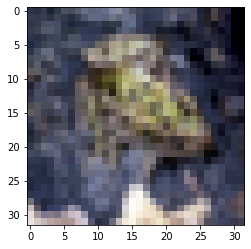

frog


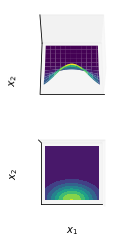

deformation maxi: 0.7006306011757408
sigX 0.3437167991729687
sigY 0.14967905224048084
cov 0.0013137319541003723


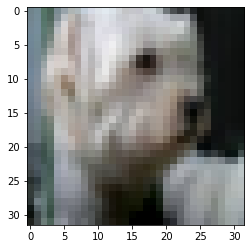

dog


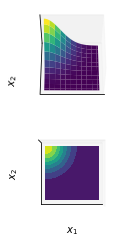

deformation maxi: 0.4631801986878999
sigX 0.3341518378416668
sigY 0.3533525174324874
cov 0.0017873062112046757


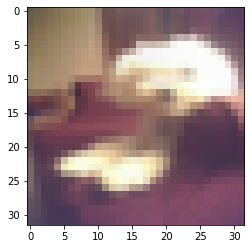

dog


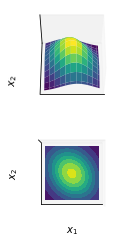

deformation maxi: 0.4116730022877956
sigX 0.37496980844811745
sigY 0.41667896237520674
cov 0.08616417224975259


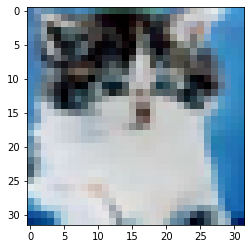

cat


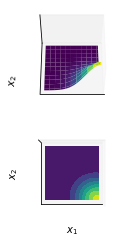

deformation maxi: 0.5977826650738155
sigX 0.2810100996460974
sigY 0.25461057521412456
cov 0.025753828580942453


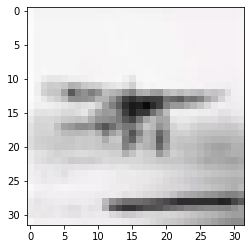

plane


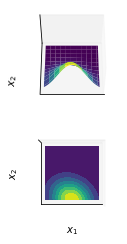

deformation maxi: 0.6305157871951904
sigX 0.26186577367248864
sigY 0.2517585020892153
cov 0.04973406327914409


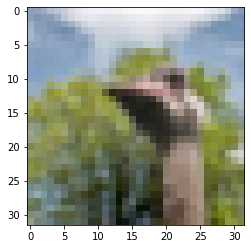

bird


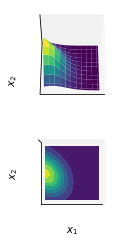

deformation maxi: 0.5843215701486173
sigX 0.2749138257665792
sigY 0.29889526241141007
cov 0.09093180461938391


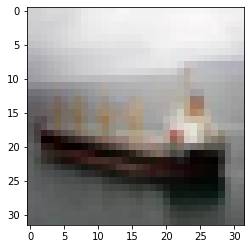

ship


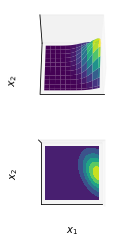

deformation maxi: 0.842561774217202
sigX 0.16036928192244515
sigY 0.25708756264346644
cov 0.07559920111216097


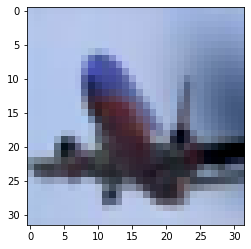

plane


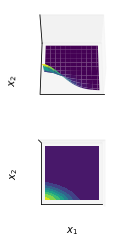

deformation maxi: 0.7233918239891901
sigX 0.4456485477308846
sigY 0.11881126783840107
cov 0.0673999380479337


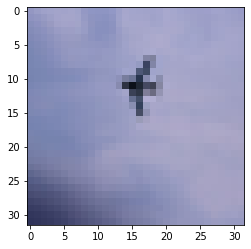

plane


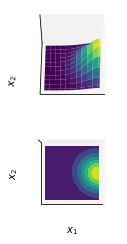

deformation maxi: 0.6765229754982635
sigX 0.24782719454811525
sigY 0.22357918581474567
cov 0.017969506728686992


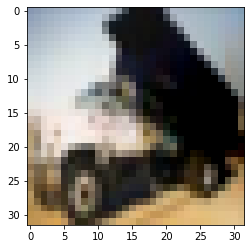

truck


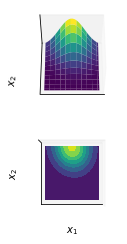

deformation maxi: 0.5820127438910087
sigX 0.22684103314942394
sigY 0.33154590929118505
cov 0.027852687408544154


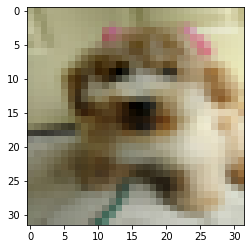

dog


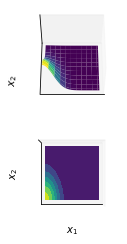

deformation maxi: 0.6453966791205462
sigX 0.12745274624505876
sigY 0.48236989600883384
cov 0.025840176204077893


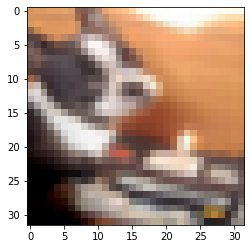

dog


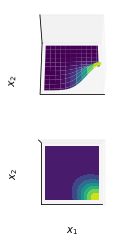

deformation maxi: 0.6949566003841054
sigX 0.2522335975020021
sigY 0.22875314286485532
cov 0.07246872187326127


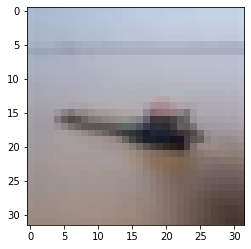

ship


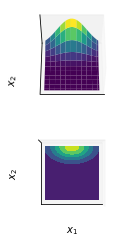

deformation maxi: 0.8303866430487374
sigX 0.3077344634178405
sigY 0.11898499745760871
cov 0.0022020839071522857


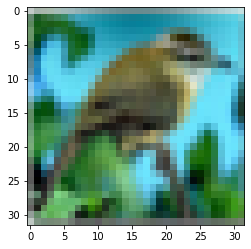

bird


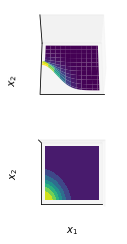

deformation maxi: 0.552309787660934
sigX 0.2481543307159147
sigY 0.3504209356332252
cov 0.06261687930781328


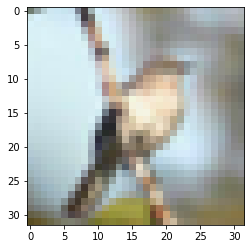

bird


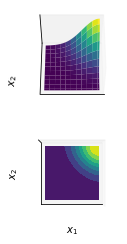

deformation maxi: 0.39864552017028126
sigX 0.39174410189696685
sigY 0.42025541874892314
cov 0.07239194447140743


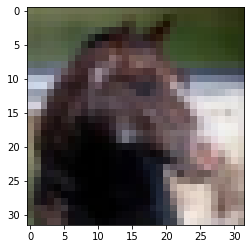

horse


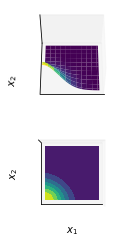

deformation maxi: 0.5551452699309938
sigX 0.32189375929393316
sigY 0.2630902523422789
cov 0.0499559531048687


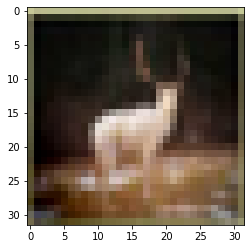

deer


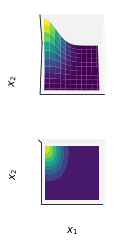

deformation maxi: 0.6007187336176716
sigX 0.1829431237311841
sigY 0.3990224732465685
cov 0.052959926547484694


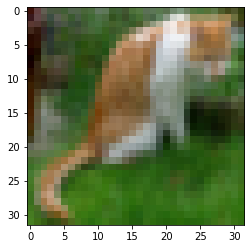

cat


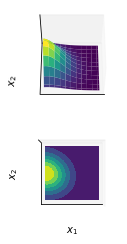

deformation maxi: 0.5535678033275455
sigX 0.3333213691645714
sigY 0.2504182493978492
cov 0.0340106119055536


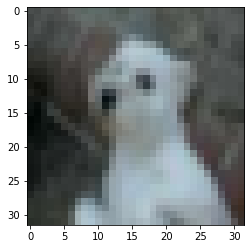

dog


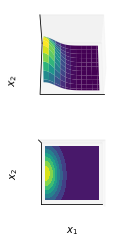

deformation maxi: 0.6035365044402269
sigX 0.15271636921194143
sigY 0.45620051274083684
cov 0.01698893118071132


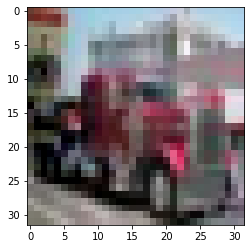

truck


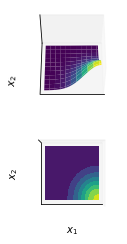

deformation maxi: 0.4389575602064235
sigX 0.3288792308819496
sigY 0.4005485197743165
cov 0.01648072422725474


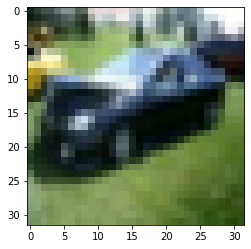

car


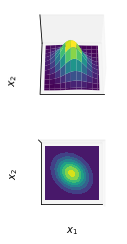

deformation maxi: 1.090191735995568
sigX 0.15381490504009282
sigY 0.14614801982526404
cov 0.03745310557583035


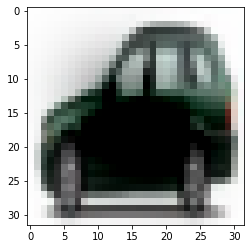

car


In [12]:
tweaked_list = []
for i in range(images.shape[0]):
    tweaked = tweak.apply_tweak(images[i],norm_mean,norm_std)
    print(classes[labels[i]])
    tweaked_list.append(tweaked)

In [ ]:
vs=[0.1,0.5]
random.uniform(vs)

In [ ]:
plt.imshow(-Z)

In [ ]:
plt.imshow(my_img[:,:,0]-Z)

In [ ]:
new_img = my_img[:,:,0]-Z
print(new_img.min(),new_img.max())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

img_size=32
# Our 2-dimensional distribution will be over variables X and Y
N = img_size #32 #40
# r1 = [random.uniform(1, 3) for _ in range(4)]
X = np.linspace(-1, 1, N) #np.linspace(-r1[0], r1[1], N) #np.linspace(-2, 2, N)
Y = np.linspace(-1, 1, N) #np.linspace(-r1[2], r1[3], N) #np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
muxy = [random.randint(-1, 1) for _ in range(2)]
mu = np.array([muxy[0], muxy[1]]) #np.array([0., 0.])

sigxy = [random.uniform(0.1,0.5) for _ in range(2)]
cov = random.uniform(0,0.1)
while sigxy[0]*sigxy[1]<cov**2 :
    sigxy = [random.uniform(0.1,0.5) for _ in range(2)]
    cov = random.uniform(0,0.1)

Sigma = np.array([[ sigxy[0] , cov], [cov,  sigxy[1]]]) #np.array([[ 1. , -0.5], [-0.5,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z = tweak.multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1,projection='3d')

ax1.plot_surface(-X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,0)  #view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(2,1,2,projection='3d')
ax2.contourf(-X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90,0) #view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()

print("deformation maxi:",Z.max())
print("sigX",sigxy[0])
print("sigY",sigxy[1])
print("cov",cov)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(90,90)
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
